223/223 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step
Combined Classification Report:
                precision    recall  f1-score   support

       Asphalt       0.91      0.81      0.85       891
 Asphalt_Night       0.93      0.97      0.95       891
      Concrete       0.90      0.95      0.93       891
Concrete_Night       0.99      0.91      0.95       891
         Grass       0.97      0.93      0.95       891
   Grass_Night       0.94      0.95      0.94       891
          Sand       0.87      0.98      0.92       891
    Sand_Night       0.97      0.98      0.97       891

      accuracy                           0.93      7128
     macro avg       0.93      0.93      0.93      7128
  weighted avg       0.93      0.93      0.93      7128

Combined Accuracy: 0.9332210998877666
Combined Log Loss: 0.2892950931845654


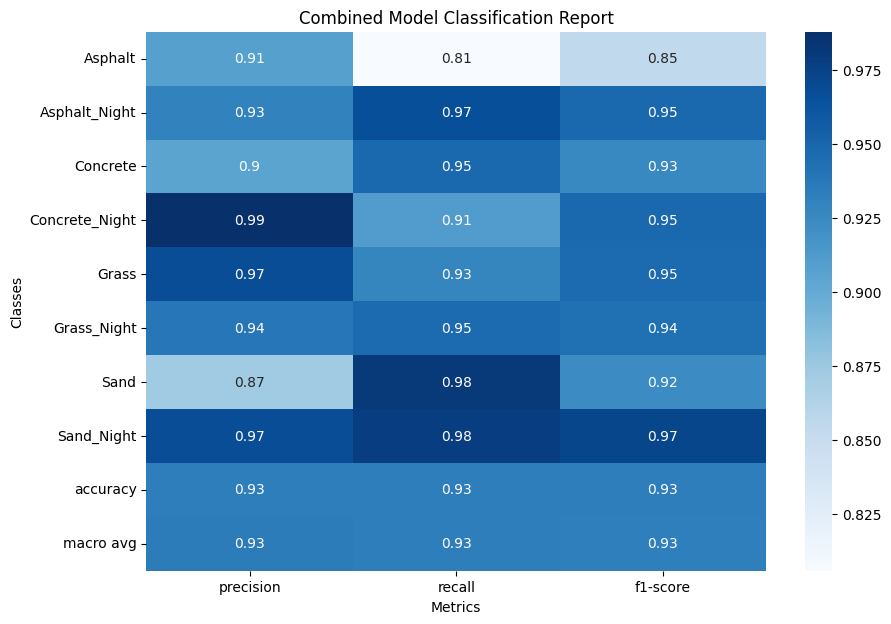

Combined Confusion Matrix:
[[718   0  71   0   1   0 101   0]
 [  0 861   0   8   0  10   0  12]
 [  8   0 845   0  17   0  21   0]
 [  0  13  16 812   0  33   0  17]
 [ 58   0   1   0 827   0   5   0]
 [  0  45   0   2   0 844   0   0]
 [  6   0   1   0  10   0 874   0]
 [  0   6   0   0   0  13   1 871]]


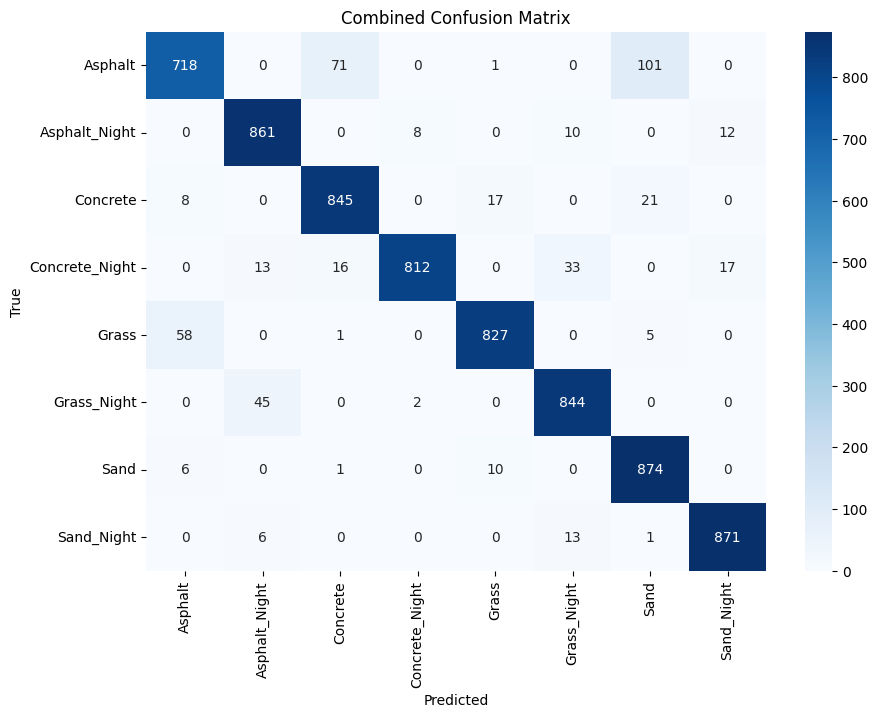

In [11]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.models import load_model
from joblib import load
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CNN model and LabelBinarizer
cnn_model = load_model('cnn_floor_type_classifier_optimized_with_augmentation222.keras')
label_binarizer = load('label_binarizer.joblib')

# Load the SVM model
svm_model = load('E:\\Files of UOSJ\\Fourth Year\\Seventh Semester\\Research\\RestNet50\\Latest model\\svm_classifier_tuned_with_probabilities_night.joblib')

# Determine if a timestamp is during the day or night
def day_or_night(timestamp):
    time = datetime.strptime(timestamp, '%I:%M:%S %p').time()
    if time >= datetime.strptime('6:00:00 AM', '%I:%M:%S %p').time() and time < datetime.strptime('5:00:00 PM', '%I:%M:%S %p').time():
        return 'day'
    else:
        return 'night'

test_csv_path = 'E:\\Files of UOSJ\\Fourth Year\\Seventh Semester\\Research\\RestNet50\\Updated_LidarDataset2.csv'
test_data = pd.read_csv(test_csv_path)

# Create the Day/Night feature
test_data['Day/Night'] = test_data['Timestamp'].apply(day_or_night)

# Load and preprocess images
def load_and_preprocess_images(image_paths):
    images = []
    for img_path in image_paths:
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize to uniform 64x64 pixels
                images.append(img)
            else:
                print(f"Warning: Image {img_path} could not be read")
        else:
            print(f"Warning: Image path {img_path} does not exist")
    images = np.array(images)
    if len(images) == 0:
        raise ValueError("No valid images found. Please check the image paths.")
    images = images.astype('float32') / 255.0
    return images

# Load and preprocess the images
test_images = load_and_preprocess_images(test_data['Image_Path'])

# Prepare LiDAR data
X_lidar = test_data[['Moving Average Strength 30', 'WTC Strength at scale 5', 'Distance x ROC Strength', 'Day/Night']]
X_lidar = pd.get_dummies(X_lidar)  # Convert categorical data to numerical format

# Standardize the features
scaler = StandardScaler()
X_lidar_scaled = scaler.fit_transform(X_lidar)

# Predict probabilities using the CNN model
cnn_prob_predictions = cnn_model.predict(test_images)

# Predict probabilities using the SVM model
svm_prob_predictions = svm_model.predict_proba(X_lidar_scaled)

# Assuming equal weights for simplicity
cnn_weight = 0.4
svm_weight = 0.6

# Weighted averaging of probabilities
combined_prob_predictions = cnn_weight * cnn_prob_predictions + svm_weight * svm_prob_predictions

# Determine the final predictions
combined_label_predictions = np.argmax(combined_prob_predictions, axis=1)

# Evaluate the combined model
true_labels = label_binarizer.transform(test_data['Floor Type'])
true_labels = np.argmax(true_labels, axis=1)

print("Combined Classification Report:")
classification_rep = classification_report(true_labels, combined_label_predictions, target_names=label_binarizer.classes_, output_dict=True)
print(classification_report(true_labels, combined_label_predictions, target_names=label_binarizer.classes_))
print("Combined Accuracy:", accuracy_score(true_labels, combined_label_predictions))
combined_logloss = log_loss(true_labels, combined_prob_predictions)
print("Combined Log Loss:", combined_logloss)

classification_df = pd.DataFrame(classification_rep).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(classification_df.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title('Combined Model Classification Report')
plt.ylabel('Classes')
plt.xlabel('Metrics')
plt.show()

combined_conf_matrix = confusion_matrix(true_labels, combined_label_predictions)
print("Combined Confusion Matrix:")
print(combined_conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(combined_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix') 
plt.show()
